<h2>Import Libraries</h2>

In [1]:
from scjpnlib.utils.file_io import FileManager
import os 
import scjpnlib.utils as scjpnutils
import pickle
import json
from IPython.core.display import HTML, Markdown
import html2text
from bs4 import BeautifulSoup
import pprint

import pandas as pd
import numpy as np

from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import scjpnlib.utils.preprocessing_strategy_transformers as scjpnpreprocessing

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from scipy.stats import reciprocal, uniform
import dask_ml.model_selection as dcv
from dask.distributed import Client
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from catboost import CatBoostClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

n_jobs = 8

LOG_MODEL_TRIALS = True

## Read Configs for this Experiment

In [2]:
fm = FileManager()

preprocessing_config = fm.load_json('preprocessing-config.txt')
models_config = fm.load_json('models-config.txt')
models_config

{'logging': {'dir': 'model-results'},
 'cross_validation': {'k': {'grid_search': 3, 'score': 5}},
 'dask': {'use': False,
  'is_remote': False,
  'local': {'n_workers': 1, 'n_jobs': 8, 'memory_limit': '16GB'},
  'remote': {'scheduler_address': '35.230.13.87'}},
 'SEED': 42,
 'DecisionTreeClassifier': {'run': True,
  'trials': {'run': True,
   'array': [{'gridsearch': {'run': True,
      'param_grid': {'criterion': ['entropy', 'gini'],
       'splitter': ['best'],
       'max_depth': [10, 50, 75, None],
       'min_samples_split': [2],
       'max_features': ['auto', 'sqrt', 'log2']},
      'last_best': {'criterion': 'gini',
       'max_depth': 10,
       'max_features': 'auto',
       'min_samples_split': 2,
       'random_state': 42,
       'splitter': 'best'}}}]},
  'params': {'criterion': 'gini',
   'max_depth': 10,
   'max_features': 'auto',
   'min_samples_split': 2,
   'random_state': 42,
   'splitter': 'best'}},
 'RandomForestClassifier': {'run': True,
  'trials': {'run': True,


In [3]:
is_data_cached = 'data_cached' in models_config
data_config = models_config['data_cached'] if is_data_cached else fm.load_json('preprocessing-config.txt')

In [4]:
if len(data_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = data_config['wrangled_data']['dir'] + "/"
else:
    WRANGLED_DATA_DIR = ""

if len(data_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = data_config['labels']['dir'] + "/"
else:
    SAVE_LABELS_DIR = ""

In [5]:
preprocessing_spec = fm.load_json(WRANGLED_DATA_DIR + "preprocessing-spec-last.json")

In [6]:
digest = data_config['digest'] if is_data_cached else scjpnutils.json_to_md5_hash_digest(preprocessing_spec)
print(f"digest for last preprocessing spec: {digest}")                                                                                      

digest for last preprocessing spec: 8a48b1bceea8e4f07957e8a9efbe76d8


In [7]:
fname__train_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(data_config, preprocessing_config, data_kwargs={'is_labels':False,'type':'train','is_cached':is_data_cached})
fname__train_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(data_config, preprocessing_config, data_kwargs={'is_labels':True,'type':'train','is_cached':is_data_cached})
fname__validation_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(data_config, preprocessing_config, data_kwargs={'is_labels':False,'type':'test','is_cached':is_data_cached})
fname__validation_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(data_config, preprocessing_config, data_kwargs={'is_labels':True,'type':'test','is_cached':is_data_cached})
fname__unlabeled_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(data_config, preprocessing_config, data_kwargs={'is_labels':False,'type':'unlabeled'})

In [8]:
if len(models_config['logging']['dir']) > 0:
    MODEL_RESULTS_DIR = models_config['logging']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{MODEL_RESULTS_DIR}")
    except FileExistsError:
        pass
    MODEL_RESULTS_DIR += "/"
else:
    MODEL_RESULTS_DIR = ""
    
model_results_fname = MODEL_RESULTS_DIR + scjpnutils.get_model_result_fname(data_config, preprocessing_spec, data_kwargs={'is_cached':is_data_cached})
print(f"modeling results will be saved to: {model_results_fname}")

modeling results will be saved to: model-results/models-results-8a48b1bceea8e4f07957e8a9efbe76d8.json


In [9]:
model_results = {}
model_results['digest'] = digest
model_results['modeling_results'] = {}

In [10]:
SEED = models_config['SEED']
model_results['seed'] = SEED

In [11]:
K = models_config['cross_validation']['k']['grid_search'] # num folds for cross-val
cross_val_score_K = models_config['cross_validation']['k']['score']

<p><br>

## Load Data

In [12]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [13]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [14]:
labels = labeled_with_target[['status_group']]

In [15]:
let_labels = LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)
classes = list(let_labels.labelencoder.classes_)
classes

['functional', 'functional needs repair', 'non functional']

In [16]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [17]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)

In [18]:
data_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0)

## Prepare Test/Train Data

In [19]:
data_train, data_test, y_train, y_test = train_test_split(X_labeled, labels, test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [20]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [21]:
data_train_with_target = pd.concat([data_train, y_train_encoded], axis=1, join='inner')

In [22]:
y_test_encoded = labels_encoded.loc[y_test.index]

In [23]:
data_test_with_target = pd.concat([data_test, y_test_encoded], axis=1, join='inner')

In [24]:
data_ALL_labeled_with_target = pd.concat([data_train_with_target, data_test_with_target], axis=0)

<p><br>

## Apply Preprocessing Transformations to Training Data

In [25]:
pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

scjpnutils.analyze_values(data_train, 'data_train BEFORE preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,96,"[0.0, 1000.0, 250.0, 5000.0, 3000.0, 2400.0, 5...",0.001796,99.82,0,0.000000,None
1,date_recorded,object,352,"[2013-03-06, 2013-02-05, 2011-07-24, 2012-11-0...",0.006584,99.34,0,0.000000,None
2,funder,object,1799,"[Kiliwater, Unicef, Danida, Tasaf/tlc, Dhv, Am...",0.033651,96.63,3269,0.061149,"Int64Index([ 569, 35243, 7826, 7576, 71341,..."
3,gps_height,int64,2415,"[1424, 1358, 0, 299, -14, 1490, 1421, 915, 891...",0.045174,95.48,0,0.000000,None
4,installer,object,2035,"[Kiliwater, TWESA, Central government, TASAF/T...",0.038066,96.19,3287,0.061485,"Int64Index([ 569, 35243, 7826, 7576, 71341,..."
5,longitude,float64,51753,"[37.61840909, 30.6557619, 33.81319755, 33.1151...",0.968070,3.19,0,0.000000,None
6,latitude,float64,51755,"[-3.26320247, -3.53625, -9.47660713, -4.835553...",0.968107,3.19,0,0.000000,None
7,wpt_name,object,34085,"[Kwa Moris Assenga, Bavunja Primary School, Za...",0.637579,36.24,0,0.000000,None
8,num_private,int64,61,"[0, 34, 65, 32, 1, 8, 41, 6, 15, 3, 698, 1402,...",0.001141,99.89,0,0.000000,None
9,basin,object,9,"[Pangani, Lake Tanganyika, Lake Nyasa, Rufiji,...",0.000168,99.98,0,0.000000,None


In [26]:
data_train_preprocessed = data_train.copy()

for group_name, preprocessing_option in preprocessing_spec.items():
    composite_transformer = scjpnpreprocessing.instantiate_strategy_transformer(
        preprocessing_option, 
        group_name,
        pipeline_data_preprocessor,
        verbose=True
    )
    scjpnpreprocessing.html_prettify_strategy_transformer_description(composite_transformer)
    data_train_preprocessed = composite_transformer.fit_transform(data_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

strategy appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f96421c04d0>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964556cfd0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d47a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d4680>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d40e0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96455698c0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): num_private', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d4170>)] to pipeline
strategy "leave feature as is (do nothing): num_private" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96455790e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964557a510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

strategy appended step ['OneHot Encode: district_code', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f964557a850>] to pipeline
strategy "OneHot Encode: district_code" transformation is COMPLETE!


strategy appended step ['tfidf normalize string-categorical: ward', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d4a70>)] to pipeline


strategy "tfidf normalize string-categorical: ward" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: ward', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'ward' in X match those that were previously fit
added new feature: ward_target_encoded
strategy appended step ['drop after target encoding: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9642fb7cd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: ward" dropped feature 'ward' after target encoding
strategy transformation of feature 'ward' to 'ward_

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: lga', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'lga' in X match those that were previously fit
added new feature: lga_target_encoded
strategy appended step ['drop after target encoding: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e03a610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: lga" dropped feature 'lga' after target encoding
strategy transformation of feature 'lga' to 'lga_target_encoded' is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9645551150>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f96425c4b90>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!


strategy appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e069890>] to pipeline
strategy "drop feature: funder" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e03af90>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964557af10>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e069a10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e03ae50>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e0322d0>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e02da10>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e038790>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f965d348290>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e069a90>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: extraction_type', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96425d43b0>)] to pipeline
strategy "strip non-alphanumeric: extraction_type" transformation is COMPLETE!
strategy appended step ['OneHot Encode: extraction_type', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f9647a77fd0>] to pipeline
strategy "OneHot Encode: extraction_type" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964557a790>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9641b8cf50>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: management', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579a70>)] to pipeline
strategy "strip non-alphanumeric: management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 

strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9645a32390>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: payment_type', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579290>)] to pipeline
strategy "strip non-alphanumeric: payment_type" transformation is COMPLETE!
strategy appended step ['OneHot Encode: payment_type', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f9645a32610>] to pipeline
strategy "OneHot Encode: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e069ad0>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: water_quality', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f96455793b0>)] to pipeline
strategy "strip non-alphanumeric: water_quality" transformation is COMPLETE!
strategy appended step ['OneHot Encode: water_quality', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f963868ad50>] to pipeline
strategy "OneHot Encode: water_quality" transformation is COMPLETE!


strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f964e03a050>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: quantity', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579710>)] to pipeline
strategy "strip non-alphanumeric: quantity" transformation is COMPLETE!
strategy appended step ['OneHot Encode: quantity', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f9647aa8050>] to pipeline
strategy "OneHot Encode: quantity" transformation is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f96418f8b50>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: source', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579830>)] to pipeline
strategy "strip non-alphanumeric: source" transformation is COMPLETE!
strategy appended step ['OneHot Encode: source', <scjpnlib.utils.skl_transformers.OneHotEncodingTransformer object at 0x7f9645a21a90>] to pipeline
strategy "OneHot Encode: source" transformation is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9645a216d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9645a21510>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


strategy appended step ['strip non-alphanumeric: waterpoint_type', FunctionTransformer(func=<function C__strip_nonalphanumeric__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579560>)] to pipeline
strategy "strip non-alphanumeric: waterpoint_type" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f9645579320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.Dro

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f9647a8dfd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


In [27]:
scjpnutils.analyze_values(data_train_preprocessed, 'data_train AFTER preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,21,"[0.0, 316.0523728020951, 5.0, 10.0, 20.0, 50.0...",0.000393,99.96,0,0.0,None
1,gps_height,int64,2415,"[1424, 1358, 0, 299, -14, 1490, 1421, 915, 891...",0.045174,95.48,0,0.0,None
2,longitude,float64,51753,"[37.61840909, 30.6557619, 33.81319755, 33.1151...",0.968070,3.19,0,0.0,None
3,latitude,float64,51755,"[-3.26320247, -3.53625, -9.47660713, -4.835553...",0.968107,3.19,0,0.0,None
4,num_private,int64,61,"[0, 34, 65, 32, 1, 8, 41, 6, 15, 3, 698, 1402,...",0.001141,99.89,0,0.0,None
5,population,float64,496,"[1.0, 500.0, 0.0, 263.0, 400.0, 520.0, 350.0, ...",0.009278,99.07,0,0.0,None
6,construction_year,int64,55,"[2012, 2009, 0, 1996, 2000, 2001, 1998, 2013, ...",0.001029,99.90,0,0.0,None
7,region_code_target_encoded,float64,27,"[0.7233282286881062, 0.815005954743946, 0.8911...",0.000505,99.95,0,0.0,None
8,district_code_1,float64,2,"[1.0, 0.0]",0.000037,100.00,0,0.0,None
9,district_code_2,float64,2,"[0.0, 1.0]",0.000037,100.00,0,0.0,None


In [28]:
data_train = data_train_preprocessed
null_labeled = data_train.isnull().values.any()

<p><br>

## Apply Preprocessing Transformations (using the `Pipeline`) to Testing Data

In [29]:
scjpnutils.analyze_values(data_test, 'data_test BEFORE preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,56,"[0.0, 5000.0, 30.0, 8000.0, 50.0, 500.0, 1500....",0.009428,99.06,0,0.000000,None
1,date_recorded,object,310,"[2013-03-13, 2011-03-15, 2013-02-19, 2013-01-1...",0.052189,94.78,0,0.000000,None
2,funder,object,622,"[Danida, Kalitasi, Wateraid, Gaica, Lga, W.B, ...",0.104714,89.53,366,0.061616,"Int64Index([11582, 19363, 56691, 5592, 33874,..."
3,gps_height,int64,1717,"[1435, 1271, 1384, 1538, 0, 919, 78, 1266, 324...",0.289057,71.09,0,0.000000,None
4,installer,object,681,"[DANIDA, DANID, Kalitasi, SEMA, GAICA, DWE, Ca...",0.114646,88.54,368,0.061953,"Int64Index([11582, 19363, 56691, 5592, 33874,..."
5,longitude,float64,5782,"[34.90829229, 35.81058308, 37.99252752, 34.758...",0.973401,2.66,0,0.000000,None
6,latitude,float64,5782,"[-11.16992903, -7.50962812, -4.23701933, -4.30...",0.973401,2.66,0,0.000000,None
7,wpt_name,object,4588,"[Kanisani, none, Kwa Mzee Tadei, Kulumbe, Shul...",0.772391,22.76,0,0.000000,None
8,num_private,int64,33,"[0, 6, 120, 17, 7, 32, 180, 93, 5, 8, 1, 15, 3...",0.005556,99.44,0,0.000000,None
9,basin,object,9,"[Lake Nyasa, Rufiji, Pangani, Internal, Lake R...",0.001515,99.85,0,0.000000,None


In [30]:
data_test_preprocessed = pipeline_data_preprocessor.transform(data_test)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 1 categories of 'ward' occur in X (out of 1626 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'ward' has 7 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: ward_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 1 categories of 'lga' occur in X (out of 125 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'lga' has 1 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: lga_target_encoded
** TargetEncoderLOOT

In [31]:
scjpnutils.analyze_values(data_test_preprocessed, 'data_test AFTER preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,17,"[0.0, 316.0523728020951, 30.0, 50.0, 20.0, 10....",0.002862,99.71,0,0.0,None
1,gps_height,int64,1717,"[1435, 1271, 1384, 1538, 0, 919, 78, 1266, 324...",0.289057,71.09,0,0.0,None
2,longitude,float64,5782,"[34.90829229, 35.81058308, 37.99252752, 34.758...",0.973401,2.66,0,0.0,None
3,latitude,float64,5782,"[-11.16992903, -7.50962812, -4.23701933, -4.30...",0.973401,2.66,0,0.0,None
4,num_private,int64,33,"[0, 6, 120, 17, 7, 32, 180, 93, 5, 8, 1, 15, 3...",0.005556,99.44,0,0.0,None
5,population,float64,289,"[60.0, 1.0, 15.0, 189.0, 0.0, 200.0, 454.0, 16...",0.048653,95.13,0,0.0,None
6,construction_year,int64,54,"[1995, 1990, 2002, 2006, 0, 2009, 2005, 2011, ...",0.009091,99.09,0,0.0,None
7,region_code_target_encoded,float64,26,"[0.8034439311213776, 0.4130343671416597, 0.723...",0.004377,99.56,0,0.0,None
8,district_code_1,float64,2,"[0.0, 1.0]",0.000337,99.97,0,0.0,None
9,district_code_2,float64,2,"[0.0, 1.0]",0.000337,99.97,0,0.0,None


In [32]:
data_test = data_test_preprocessed
null_labeled = null_labeled and data_test.isnull().values.any()
data_ALL_labeled = pd.concat([data_train, data_test], axis=0).sort_index()

<p><br>

## Apply Preprocessing Transformations (using the `Pipeline`) to Unlabeled Data

In [33]:
scjpnutils.analyze_values(data_unlabeled, 'data_unlabeled BEFORE preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,68,"[0.0, 500.0, 30.0, 5.0, 1000.0, 1200.0, 200.0,...",0.004579,99.54,0,0.000000,None
1,date_recorded,object,331,"[2013-02-04, 2013-02-01, 2013-01-22, 2013-03-2...",0.022290,97.77,0,0.000000,None
2,funder,object,981,"[Dmdd, Government Of Tanzania, nan, Finn Water...",0.066061,93.39,869,0.058519,"Int64Index([17168, 27714, 30331, 15266, 51897,..."
3,gps_height,int64,2157,"[1996, 1569, 1567, 267, 1260, 1685, 550, 234, ...",0.145253,85.47,0,0.000000,None
4,installer,object,1092,"[DMDD, DWE, nan, FINN WATER, BRUDER, Gover, Fi...",0.073535,92.65,877,0.059057,"Int64Index([17168, 27714, 30331, 15266, 51897,..."
5,longitude,float64,14390,"[35.2907992, 36.65670893, 34.76786315, 38.0580...",0.969024,3.10,0,0.000000,None
6,latitude,float64,14390,"[-4.05969643, -3.30921425, -5.00434437, -9.418...",0.969024,3.10,0,0.000000,None
7,wpt_name,object,10840,"[Dinamu Secondary School, Kimnyak, Puma Second...",0.729966,27.00,0,0.000000,None
8,num_private,int64,36,"[0, 3, 93, 1, 22, 102, 6, 5, 16, 669, 11, 7, 2...",0.002424,99.76,0,0.000000,None
9,basin,object,9,"[Internal, Pangani, Ruvuma / Southern Coast, R...",0.000606,99.94,0,0.000000,None


In [34]:
data_unlabeled_preprocessed = pipeline_data_preprocessor.transform(data_unlabeled)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 1 categories of 'ward' occur in X (out of 1949 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'ward' has 14 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: ward_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 1 categories of 'lga' occur in X (out of 125 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'lga' has 1 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: lga_target_encoded
** TargetEncoderLOO

In [35]:
scjpnutils.analyze_values(data_unlabeled_preprocessed, 'data_unlabeled AFTER preprocessing');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,amount_tsh,float64,20,"[0.0, 316.0523728020951, 30.0, 5.0, 20.0, 50.0...",0.001347,99.87,0,0.0,None
1,gps_height,int64,2157,"[1996, 1569, 1567, 267, 1260, 1685, 550, 234, ...",0.145253,85.47,0,0.0,None
2,longitude,float64,14390,"[35.2907992, 36.65670893, 34.76786315, 38.0580...",0.969024,3.10,0,0.0,None
3,latitude,float64,14390,"[-4.05969643, -3.30921425, -5.00434437, -9.418...",0.969024,3.10,0,0.0,None
4,num_private,int64,36,"[0, 3, 93, 1, 22, 102, 6, 5, 16, 669, 11, 7, 2...",0.002424,99.76,0,0.0,None
5,population,float64,446,"[321.0, 300.0, 500.0, 250.0, 60.0, 200.0, 179....",0.030034,97.00,0,0.0,None
6,construction_year,int64,55,"[2012, 2000, 2010, 1987, 1990, 2007, 1982, 199...",0.003704,99.63,0,0.0,None
7,region_code_target_encoded,float64,26,"[0.6803621169916435, 0.6278043398308202, 0.971...",0.001751,99.82,0,0.0,None
8,district_code_1,float64,2,"[0.0, 1.0]",0.000135,99.99,0,0.0,None
9,district_code_2,float64,2,"[0.0, 1.0]",0.000135,99.99,0,0.0,None


In [36]:
data_unlabeled = data_unlabeled_preprocessed
null_unlabeled = data_unlabeled.isnull().values.any()

<p><br>
<h2>Build Models (Run Trials)</h2>

<h3>General functions for building Classifiers and running trials</h3>

In [37]:
# utility function to render HTML and optionally log (append) it to file
def render_HTML(the_html, fname=None):
    display(HTML(the_html))
    if fname is not None:
        fm.append_text_file(BeautifulSoup(the_html).text + '\n', fname)

In [38]:
def get_trials_log_fname(clf):
    return f"{MODEL_RESULTS_DIR}{clf.__class__.__name__}-{digest}-trials.log" if LOG_MODEL_TRIALS else None

In [39]:
def gs_find_best_params(clf, param_grid):
    render_HTML(f"<br><br>param_grid for {clf.__class__.__name__} GridSearch:<br><pre>{param_grid}</pre>", fname=get_trials_log_fname(clf))
    grid_clf = GridSearchCV(
        clf, 
        param_grid, 
        cv=K, 
        n_jobs=-1
        , verbose=20
    )
    # with joblib.parallel_backend('dask'):
    #     %time _ = grid_clf.fit(data_train, y_train)
    %time _ = grid_clf.fit(data_train, y_train)
    return grid_clf.best_params_

In [40]:
def clf_fit(clf, data_train, y_train):
    # with joblib.parallel_backend('dask'):
    #     %time clf.fit(data_train, y_train)
    %time clf.fit(data_train, y_train)
    return clf

In [41]:
# adapted from https://datascience.stackexchange.com/a/40068
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [42]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    _accuracy = accuracy_score(y, preds)
    render_HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}", fname=get_trials_log_fname(clf))
    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>", fname=get_trials_log_fname(clf))
    
    df_preds = pd.concat([X.reset_index()[['id']], pd.DataFrame(preds, columns=['status_group_encoded'])], axis=1).set_index('id')
    df_preds['status_group'] = df_preds['status_group_encoded'].apply(lambda sg_encoded: classes[sg_encoded])
    df_preds = df_preds.drop('status_group_encoded', axis=1)

    cnf_matrix = confusion_matrix(labels.loc[y.index].status_group, df_preds.status_group, labels=classes)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')
    plt.show()
    
    return _accuracy

In [43]:
def get_feat_importances(clf):
    if hasattr(clf, 'feature_importances_'):
        feat_importances = {}
        for i, feat in enumerate(list(data_train.columns)):
            feat_importances[feat] = clf.feature_importances_[i]
        return sorted(list(feat_importances.items()), key=lambda item: item[1], reverse=True)
    else:
        return None

In [44]:
def clf_run_trial(clf, params_to_try, best_parameters_so_far, run_trials_gridsearch=False, compute_cv_score=False):
    if run_trials_gridsearch:
        for param_name, param_value in best_parameters_so_far.items():
            params_to_try.update({param_name: [param_value]})
        best_parameters = gs_find_best_params(clf, params_to_try)
    else:
        best_parameters = params_to_try
    best_parameters_so_far.update(best_parameters)

    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML(f"Grid Search {'(previously) ' if not run_trials_gridsearch else ''}found the following optimal parameters: ", fname=get_trials_log_fname(clf))
    render_HTML(f"<pre>{pprint.pformat(best_parameters_so_far, indent=4)}</pre>", fname=get_trials_log_fname(clf))

#     _y_train = y_train_encoded.status_group.ravel()
#     _y_test = y_test_encoded.status_group.ravel()
    _y_train = y_train_encoded.status_group
    _y_test = y_test_encoded.status_group
    
    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML("Fitting classifier...", fname=get_trials_log_fname(clf))
    clf = clf.set_params(**best_parameters_so_far)
    clf = clf_fit(clf, data_train, _y_train)
    s_all_done = "\tALL DONE!"
    render_HTML(f"<pre>{s_all_done}</pre>", fname=get_trials_log_fname(clf))

    _class_name = clf.__class__.__name__
    model_results['modeling_results'][_class_name] = {}

    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML("Predicting labels on training data...", fname=get_trials_log_fname(clf))
    pred_train = clf.predict(data_train)
    render_HTML(f"<pre>{s_all_done}</pre>", fname=get_trials_log_fname(clf))
    _accuracy_train = summarize_preds(clf, data_train, _y_train, pred_train, 'Training', classes)
    model_results['modeling_results'][_class_name]['accuracy'] = {}
    model_results['modeling_results'][_class_name]['accuracy']['train'] = _accuracy_train

    if compute_cv_score:
        render_HTML("<p><br>")
        render_HTML("Computing cross-val score on training data...")
        model_results['modeling_results'][_class_name]['cv_score'] = {}
        cv_score_train = cross_val_score(clf, data_train, _y_train, cv=cross_val_score_K)
        mean_cv_score_train = np.mean(cv_score_train)
        model_results['modeling_results'][_class_name]['cv_score']['train'] = mean_cv_score_train
        render_HTML(f"<pre>{s_all_done} scores: {cv_score_train}</pre>")
        render_HTML(f"cross_val_score: {mean_cv_score_train}")

    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML(f"Predicting labels on testing data...", fname=get_trials_log_fname(clf))
    pred_test = clf.predict(data_test)
    render_HTML(f"<pre>{s_all_done}</pre>", fname=get_trials_log_fname(clf))
    _accuracy_test = summarize_preds(clf, data_test, _y_test, pred_test, 'Testing', classes)
    model_results['modeling_results'][_class_name]['accuracy']['test'] = _accuracy_test
    model_results['modeling_results'][_class_name]['feature_importances'] = get_feat_importances(clf)
    
    if compute_cv_score:
        render_HTML("<p><br>")
        render_HTML(f"Computing cross-val score on testing data...")
        cv_score_test = cross_val_score(clf, data_test, _y_test, cv=cross_val_score_K)
        mean_cv_score_test = np.mean(cv_score_test)
        model_results['modeling_results'][_class_name]['cv_score']['test'] = mean_cv_score_test
        render_HTML(f"<pre>{s_all_done} scores: {cv_score_test}</pre>")
        render_HTML(f"cross_val_score: {mean_cv_score_test}")

    if hasattr(clf, 'feature_importances_'):
        render_HTML("<p><br>", fname=get_trials_log_fname(clf))
        render_HTML("Feature Importances:", fname=get_trials_log_fname(clf))
        render_HTML(f"<pre>{pprint.pformat(model_results['modeling_results'][_class_name]['feature_importances'], indent=4)}</pre><p><br><br>", fname=get_trials_log_fname(clf))

    return clf, best_parameters_so_far, model_results

In [45]:
def clf_build_final_model(clf, params):
    render_HTML("Fitting classifier {} to ALL LABALED data...")
    clf = clf.set_params(**best_parameters_so_far)
    clf = clf_fit(clf, data_ALL_labeled_with_target.drop('status_group', axis=1), data_ALL_labeled_with_target[['status_group']])
    s_all_done = "\tALL DONE!"
    render_HTML(f"<pre>{s_all_done}</pre>")

    render_HTML("<p><br>", fname=get_trials_log_fname(clf))
    render_HTML("Predicting labels of UNLABELED data...", fname=get_trials_log_fname(clf))
    pred_unlabeled = clf.predict(data_unlabeled)
    render_HTML(f"<pre>{s_all_done}</pre>", fname=get_trials_log_fname(clf))

    return 

<p><br>
<h2>Initialize Dask-Client (to Dask backend for parallelization) <i>(DISABLED for now)</i></h2>

In [46]:
if models_config['dask']['use']:
    if models_config['dask']['is_remote']:
        # for Kubernetes dask scheduler/worker cluster in GCP - but this costs money to run the cluster AND requires a lot more work for data parallelization!
        dask_client = Client(f"tcp://{models_config['dask']['remote']['scheduler_address']}:8786")
    else:
        # local
        dask_client = Client( #spawns a local cluster
            n_workers=models_config['dask']['local']['n_workers'], 
            threads_per_worker=models_config['dask']['local']['n_jobs'], 
            memory_limit=models_config['dask']['local']['memory_limit'] # memory_limit is per worker
        )

    dask_client

<p><br>
<h3>Decision Tree Classifier</h3>
<h4>Trials</h4>

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

CPU times: user 901 ms, sys: 177 ms, total: 1.08 s
Wall time: 4.99 s


CPU times: user 140 ms, sys: 10.2 ms, total: 150 ms
Wall time: 150 ms


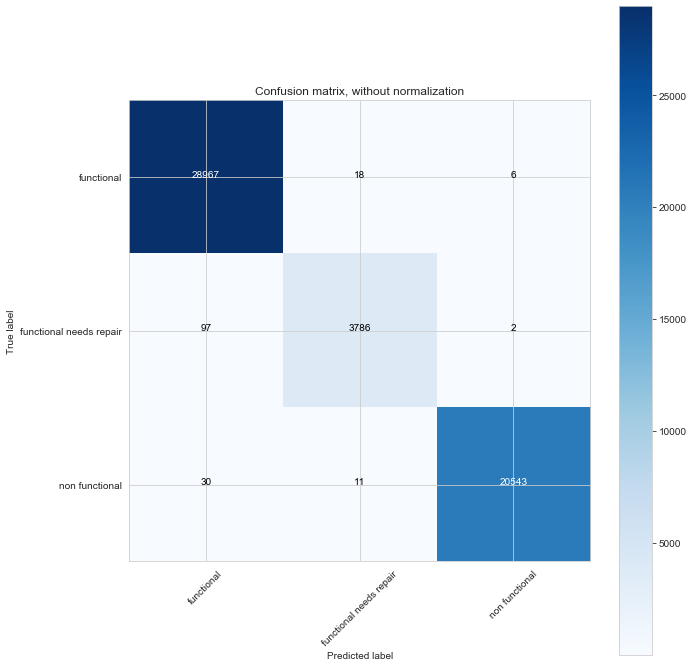

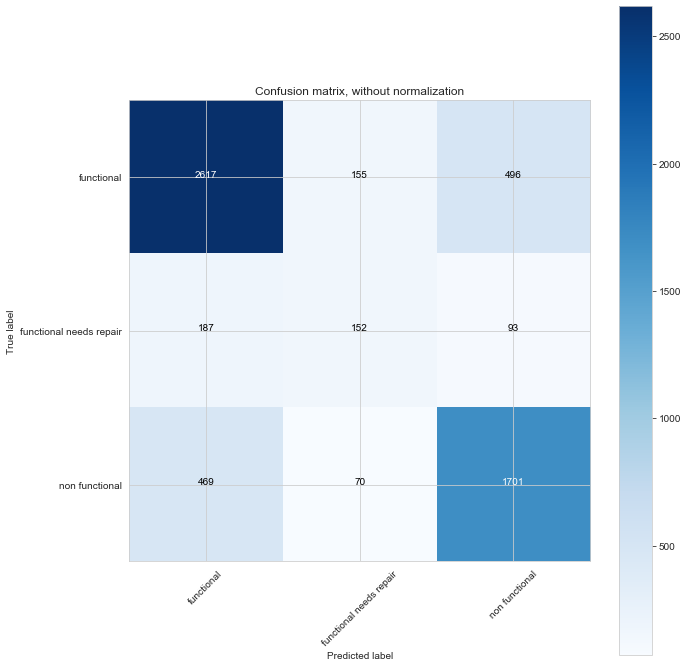

In [47]:
run_dtclf = models_config['DecisionTreeClassifier']['run'] and not null_labeled and not null_unlabeled
render_HTML(f"models_config['DecisionTreeClassifier']['run']: {models_config['DecisionTreeClassifier']['run']}; data_ALL_labeled_with_target.isnull().values.any(): {null_labeled}; data_unlabeled.isnull().values.any(): {null_unlabeled}")

if run_dtclf:
    trials = models_config['DecisionTreeClassifier']['trials']

    display(HTML(f"models_config['DecisionTreeClassifier']['trials']['run']: {trials['run']}"))
    if trials['run']:
        trials_list = trials['array']

        best_parameters = {}
        for i, trial in enumerate(trials_list):
            display(HTML(f"<p><br>trial[{i}]['gridsearch']['run']: {trial['gridsearch']['run']}<br>"))
            params = trial['gridsearch']['last_best'] if not trial['gridsearch']['run'] else trial['gridsearch']['param_grid']
            rfclf, best_parameters, model_results = clf_run_trial(DecisionTreeClassifier(), params, best_parameters, run_trials_gridsearch=trial['gridsearch']['run']) # note that best_parameters will be set to those used in the last trial

    else:
        best_parameters = models_config['DecisionTreeClassifier']['params']

<p><br>
<h4>Build Validation Final Model with best params</h4>

CPU times: user 140 ms, sys: 13 ms, total: 153 ms
Wall time: 153 ms


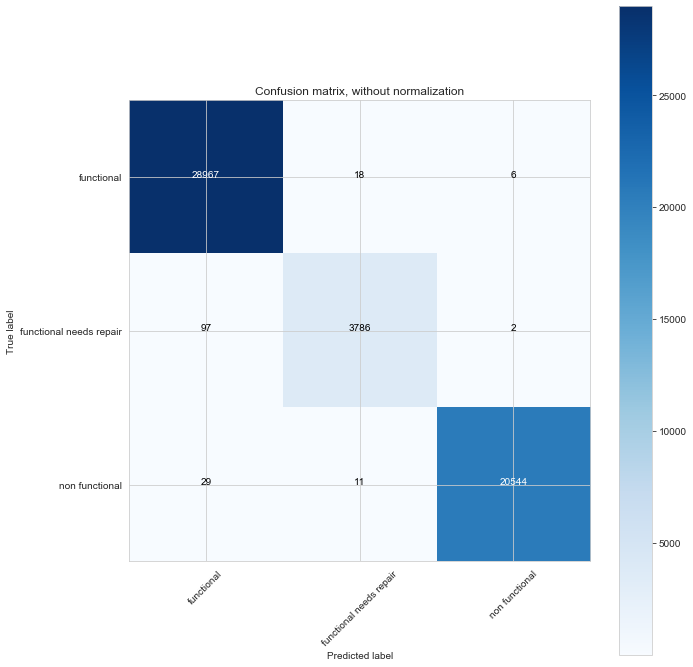

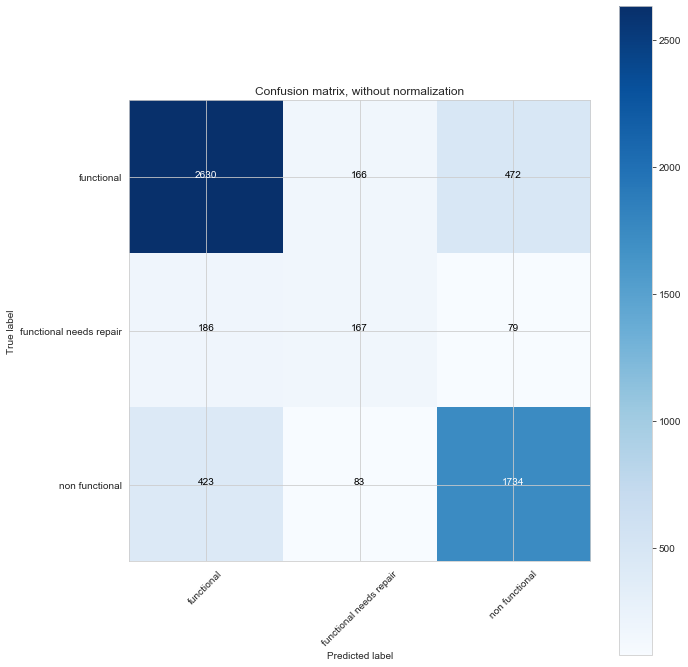

In [48]:
if run_dtclf:
    best_parameters.update({'random_state': SEED})
    dtclf, _, model_results = clf_run_trial(DecisionTreeClassifier(), best_parameters, best_parameters)
    
    pred_unlabeled = dtclf.predict(data_unlabeled)
    pred_unlabeled

<p><br><br>
<h4>Build Final Model with ALL Labeled Data (Test + Validation)</h4>

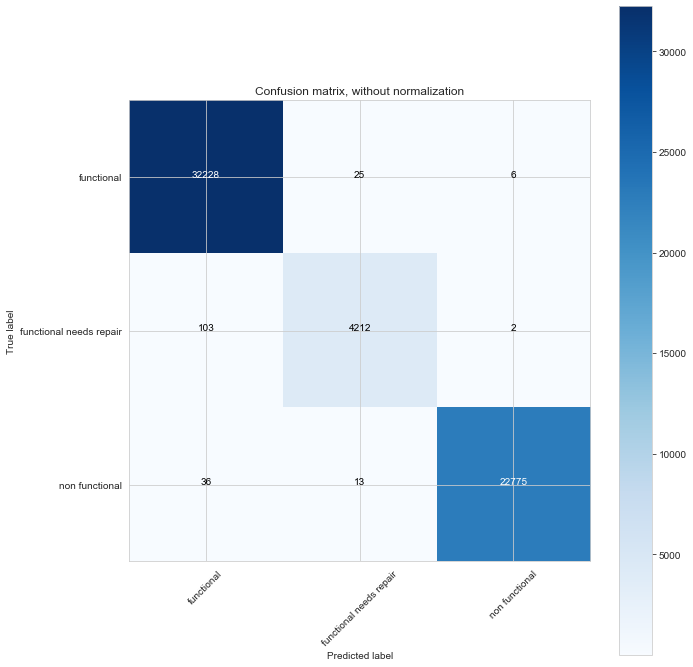

In [49]:
if run_dtclf:
    dtclf = DecisionTreeClassifier()
    del best_parameters['random_state']
    dtclf.set_params(**best_parameters)
    dtclf.fit(data_ALL_labeled, labels_encoded.status_group)
    pred_ALL = dtclf.predict(data_ALL_labeled)
    summarize_preds(dtclf, data_ALL_labeled, labels_encoded.status_group, pred_ALL, 'ALL Labeled', classes);
    
    if hasattr(dtclf, 'feature_importances_'):
        render_HTML("<p><br>", fname=get_trials_log_fname(dtclf))
        render_HTML("Feature Importances:", fname=get_trials_log_fname(dtclf))
        render_HTML(f"<pre>{pprint.pformat(model_results['modeling_results'][dtclf.__class__.__name__]['feature_importances'], indent=4)}</pre><p><br><br>", fname=get_trials_log_fname(dtclf))

<p><br><br>
<h4>Make Predictions with Final Model on Unlabeled Predictors</h4>

In [50]:
if run_dtclf:
    pred_unlabeled = dtclf.predict(data_unlabeled)
    df_pred_unlabeled = pd.concat([data_unlabeled.reset_index()[['id']], pd.DataFrame(pred_unlabeled, columns=['status_group'])], axis=1).set_index('id')
    df_pred_unlabeled.info()
    fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}DecisionTreeClassifier-preds-{digest}.csv"
    df_pred_unlabeled.to_csv(fname__preds_unlabeled, sep=',')
    print(f"updated {fname__preds_unlabeled}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   status_group  14850 non-null  int64
dtypes: int64(1)
memory usage: 232.0 KB
updated model-results/DecisionTreeClassifier-preds-8a48b1bceea8e4f07957e8a9efbe76d8.csv


<p><br>
<h4>Supplemental: Wrap <code>DecisionTreeClassifier</code> within <code>BaggingClassifier</code> (for comparison to <code>RandomForestClassifier</code>)</h4>

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.3s finished


CPU times: user 12.8 s, sys: 750 ms, total: 13.5 s
Wall time: 13.5 s


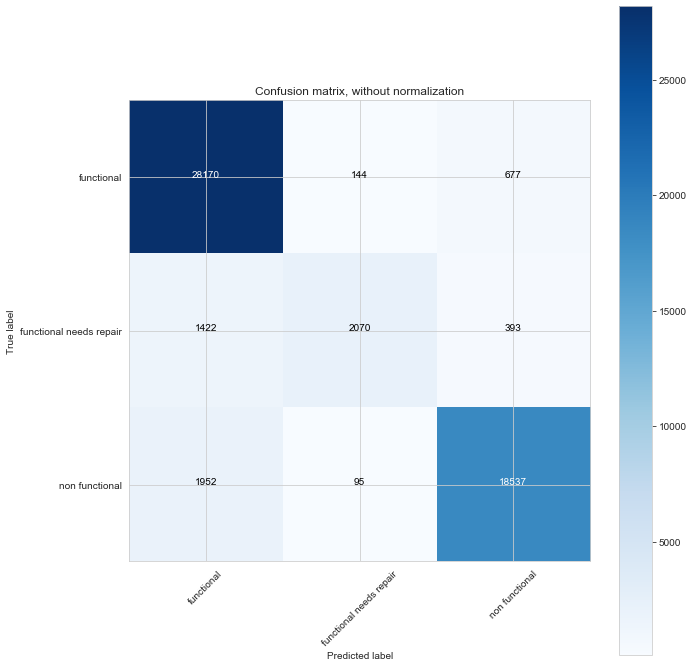

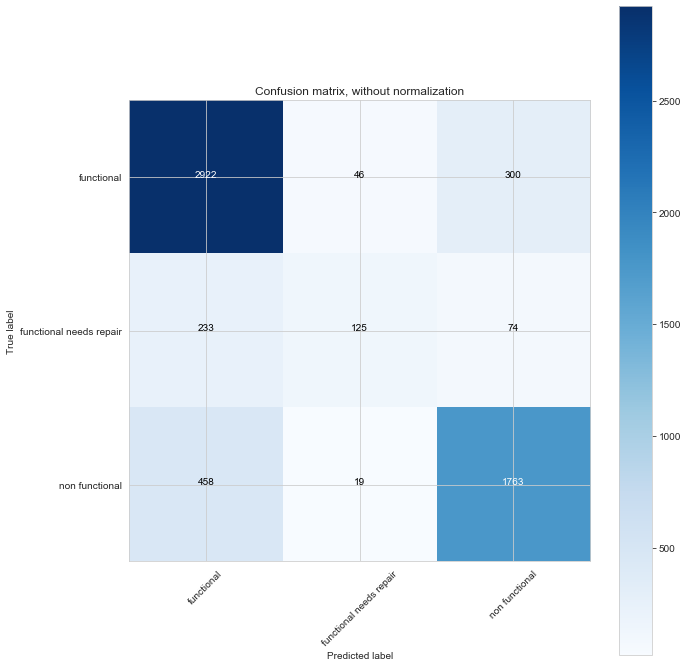

In [51]:
if run_dtclf:
    _y_train = y_train_encoded.status_group.ravel()
    _y_test = y_test_encoded.status_group.ravel()

    n_iter = 100
    bagging_dtclf = BaggingClassifier(base_estimator=dtclf)
    param_distributions = {
        'n_estimators': list(range(10,1001)),
#         'max_depth': list(range(10,101)) + [None], # invalid
        'max_features': reciprocal(0.0001, 1),
        'bootstrap': [True, False],
        'max_samples': reciprocal(0.0001, 1),
        'bootstrap_features': [True, False],
        'warm_start': [True, False]
    }
    rnd_search_cv = RandomizedSearchCV(
        bagging_dtclf, 
        param_distributions, 
        n_iter=n_iter,  
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    len_rs_ds = 1000
    rnd_search_cv.fit(data_train[:len_rs_ds], _y_train[:len_rs_ds])
#     best_parameters = rnd_search_cv.best_params_
    
    bagging_dtclf, _, model_results = clf_run_trial(rnd_search_cv.best_estimator_, rnd_search_cv.best_params_, rnd_search_cv.best_params_)

<p><br>
<h3>Random Forest Classifier</h3>
<h4>Trials</h4>

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

CPU times: user 3min 11s, sys: 3.02 s, total: 3min 14s
Wall time: 1h 11min 50s


CPU times: user 3min 15s, sys: 2.45 s, total: 3min 17s
Wall time: 26.8 s


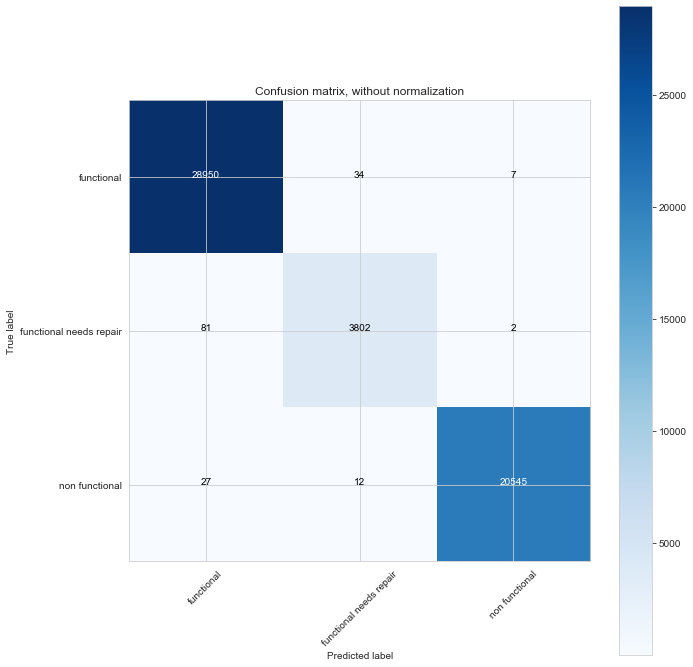

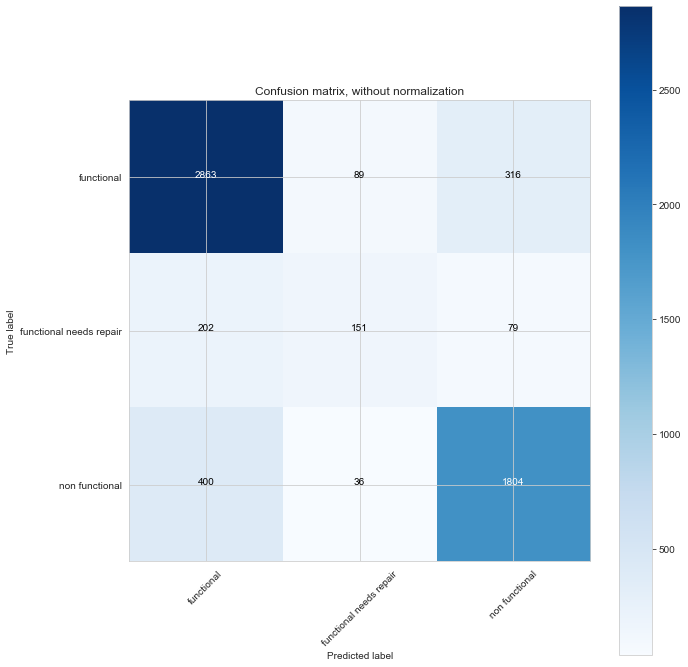

In [52]:
run_rfclf = models_config['RandomForestClassifier']['run'] and not null_labeled and not null_unlabeled
render_HTML(f"models_config['RandomForestClassifier']['run']: {models_config['RandomForestClassifier']['run']}; data_ALL_labeled_with_target.isnull().values.any(): {null_labeled}; data_unlabeled.isnull().values.any(): {null_unlabeled}")

if run_rfclf:
    trials = models_config['RandomForestClassifier']['trials']

    render_HTML(f"models_config['RandomForestClassifier']['trials']['run']: {trials['run']}")
    if trials['run']:
        trials_list = trials['array']

        best_parameters = {}
        for i, trial in enumerate(trials_list):
            render_HTML(f"<p><br>trial[{i}]['gridsearch']['run']: {trial['gridsearch']['run']}<br>")
            params = trial['gridsearch']['last_best'] if not trial['gridsearch']['run'] else trial['gridsearch']['param_grid']
            if trial['gridsearch']['run']:
                params.update({'n_jobs': [-1]})
            else:
                params.update({'n_jobs':-1})
            rfclf, best_parameters, model_results = clf_run_trial(RandomForestClassifier(), params, best_parameters, run_trials_gridsearch=trial['gridsearch']['run']) # note that best_parameters will be set to those used in the last trial
            
    else:
        best_parameters = models_config['RandomForestClassifier']['params']

<p><br>
<h4>Build Final Vaildation Model with best params</h4>

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   17.9s


CPU times: user 2min 52s, sys: 2.21 s, total: 2min 54s
Wall time: 24.3 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.9s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.5s finished


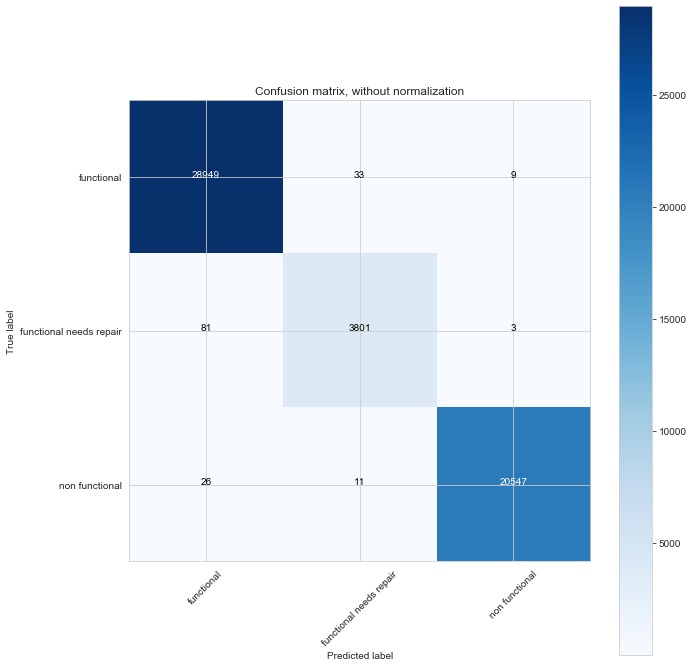

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


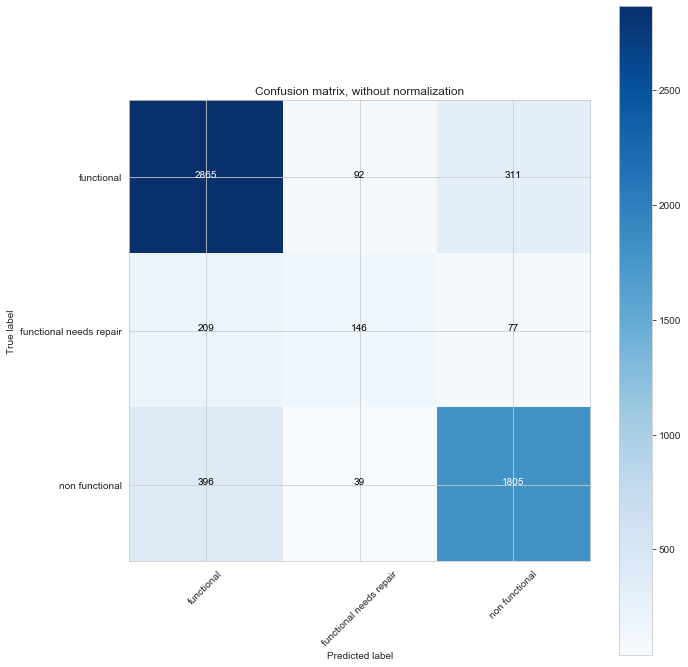

In [53]:
if run_rfclf:
    best_parameters.update({'n_jobs':-1, 'verbose':1, 'random_state': SEED})
    rfclf, _ , model_results = clf_run_trial(RandomForestClassifier(), best_parameters, best_parameters)

<p><br><br>
<h4>Build Final Model with ALL Labeled Data (Test + Validation)</h4>

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.5s finished


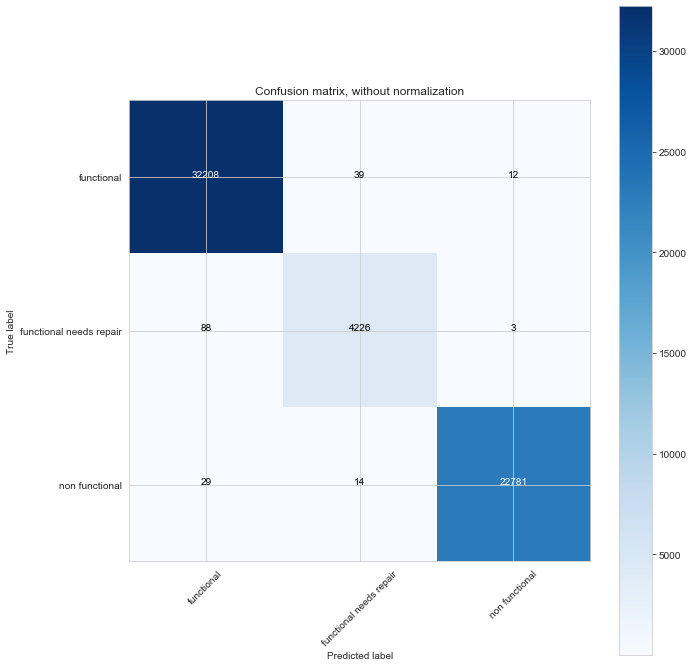

In [54]:
if run_rfclf:
    rfclf = RandomForestClassifier()
    del best_parameters['random_state']
    rfclf.set_params(**best_parameters)
    rfclf.fit(data_ALL_labeled, labels_encoded.status_group)
    pred_ALL = rfclf.predict(data_ALL_labeled)
    summarize_preds(rfclf, data_ALL_labeled, labels_encoded.status_group, pred_ALL, 'ALL Labeled', classes);
    
    if hasattr(rfclf, 'feature_importances_'):
        render_HTML("<p><br>", fname=get_trials_log_fname(rfclf))
        render_HTML("Feature Importances:", fname=get_trials_log_fname(rfclf))
        render_HTML(f"<pre>{pprint.pformat(model_results['modeling_results'][rfclf.__class__.__name__]['feature_importances'], indent=4)}</pre><p><br><br>", fname=get_trials_log_fname(rfclf))

<p><br><br>
<h4>Make Predictions with Final Model on Unlabeled Predictors</h4>

In [55]:
if run_rfclf:
    pred_unlabeled = rfclf.predict(data_unlabeled)
    df_pred_unlabeled = pd.concat([data_unlabeled.reset_index()[['id']], pd.DataFrame(pred_unlabeled, columns=['status_group'])], axis=1).set_index('id')
    df_pred_unlabeled.info()
    fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}RandomForestClassifier-preds-{digest}.csv"
    df_pred_unlabeled.to_csv(fname__preds_unlabeled, sep=',')
    print(f"updated {fname__preds_unlabeled}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   status_group  14850 non-null  int64
dtypes: int64(1)
memory usage: 232.0 KB
updated model-results/RandomForestClassifier-preds-8a48b1bceea8e4f07957e8a9efbe76d8.csv


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


<p><br><br><br>
<h3>XGBClassifier</h3>
<h4>Trials</h4>

In [56]:
run_xgbclf = models_config['XGBClassifier']['run']
render_HTML(f"models_config['XGBClassifier']['run']: {run_xgbclf}")

if run_xgbclf:
    trials = models_config['XGBClassifier']['trials']

    render_HTML(f"models_config['XGBClassifier']['trials']['run']: {trials['run']}")
    if trials['run']:
        trials_list = trials['array']

        best_parameters = {}
        for i, trial in enumerate(trials_list):
            render_HTML(f"<p><br>trial[{i}]['gridsearch']['run']: {trial['gridsearch']['run']}<br>")
            params = trial['gridsearch']['last_best'] if not trial['gridsearch']['run'] else trial['gridsearch']['param_grid']
            if trial['gridsearch']['run']:
                params.update({'n_jobs': [-1]})
            else:
                params.update({'n_jobs':-1})
            xgbclf, best_parameters, model_results = clf_run_trial(XGBClassifier(), params, best_parameters, run_trials_gridsearch=trial['gridsearch']['run']) # note that best_parameters will be set to those used in the last trial
            
    else:
        best_parameters = models_config['XGBClassifier']['params']

<p><br>
<h4>Build Final Vaildation Model with best params</h4>

In [57]:
if run_xgbclf:
    best_parameters.update({'n_jobs':-1, 'verbosity':1, 'random_state': SEED})
    xgbclf, _ , model_results = clf_run_trial(XGBClassifier(), best_parameters, best_parameters)

<p><br><br>
<h4>Build Final Model with ALL Labeled Data (Test + Validation)</h4>

In [58]:
if run_xgbclf:
    xgbclf = XGBClassifier()
    del best_parameters['random_state']
    xgbclf.set_params(**best_parameters)
    xgbclf.fit(data_ALL_labeled, labels_encoded.status_group)
    pred_ALL = xgbclf.predict(data_ALL_labeled)
    summarize_preds(xgbclf, data_ALL_labeled, labels_encoded.status_group, pred_ALL, 'ALL Labeled', classes);
    
    if hasattr(xgbclf, 'feature_importances_'):
        render_HTML("<p><br>", fname=get_trials_log_fname(xgbclf))
        render_HTML("Feature Importances:", fname=get_trials_log_fname(xgbclf))
        render_HTML(f"<pre>{pprint.pformat(model_results['modeling_results'][xgbclf.__class__.__name__]['feature_importances'], indent=4)}</pre><p><br><br>", fname=get_trials_log_fname(xgbclf))

<p><br><br>
<h4>Make Predictions with Final Model on Unlabeled Predictors</h4>

In [59]:
if run_xgbclf:
    pred_unlabeled = xgbclf.predict(data_unlabeled)
    df_pred_unlabeled = pd.concat([data_unlabeled.reset_index()[['id']], pd.DataFrame(pred_unlabeled, columns=['status_group_encoded'])], axis=1).set_index('id')
    df_pred_unlabeled['status_group'] = df_pred_unlabeled['status_group_encoded'].apply(lambda sg_encoded: classes[sg_encoded])
    df_pred_unlabeled = df_pred_unlabeled.drop('status_group_encoded', axis=1)
    df_pred_unlabeled.info()
    fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}XGBClassifier-preds-{digest}.csv"
    df_pred_unlabeled.to_csv(fname__preds_unlabeled, sep=',')
    print(f"updated {fname__preds_unlabeled}")

<p><br><br><br>
<h3>CatBoostClassifier</h3>
<h4>Trials</h4>

In [60]:
run_cbclf = models_config['CatBoostClassifier']['run']
render_HTML(f"models_config['CatBoostClassifier']['run']: {run_cbclf}")

if run_cbclf:
    trials = models_config['CatBoostClassifier']['trials']

    render_HTML(f"models_config['CatBoostClassifier']['trials']['run']: {trials['run']}")
    if trials['run']:
        trials_list = trials['array']

        best_parameters = {}
        for i, trial in enumerate(trials_list):
            render_HTML(f"<p><br>trial[{i}]['gridsearch']['run']: {trial['gridsearch']['run']}<br>")
            params = trial['gridsearch']['last_best'] if not trial['gridsearch']['run'] else trial['gridsearch']['param_grid']
            if trial['gridsearch']['run']:
                params.update({'n_jobs': [-1]})
            else:
                params.update({'n_jobs':-1})
            cbclf, best_parameters, model_results = clf_run_trial(CatBoostClassifier(verbose=False), params, best_parameters, run_trials_gridsearch=trial['gridsearch']['run']) # note that best_parameters will be set to those used in the last trial

    else:
        best_parameters = models_config['CatBoostClassifier']['params']

<p><br>
<h4>Build Final Vaildation Model with best params</h4>

CPU times: user 11min 35s, sys: 1min 26s, total: 13min 2s
Wall time: 2min 7s


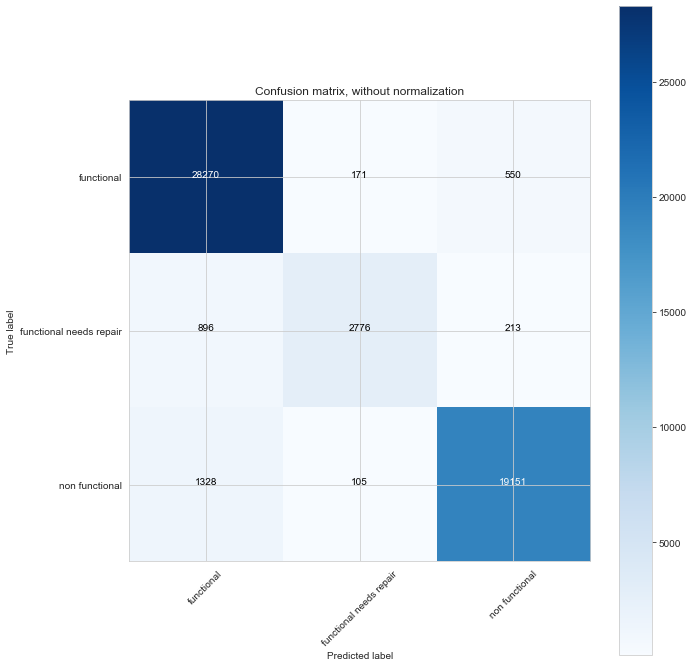

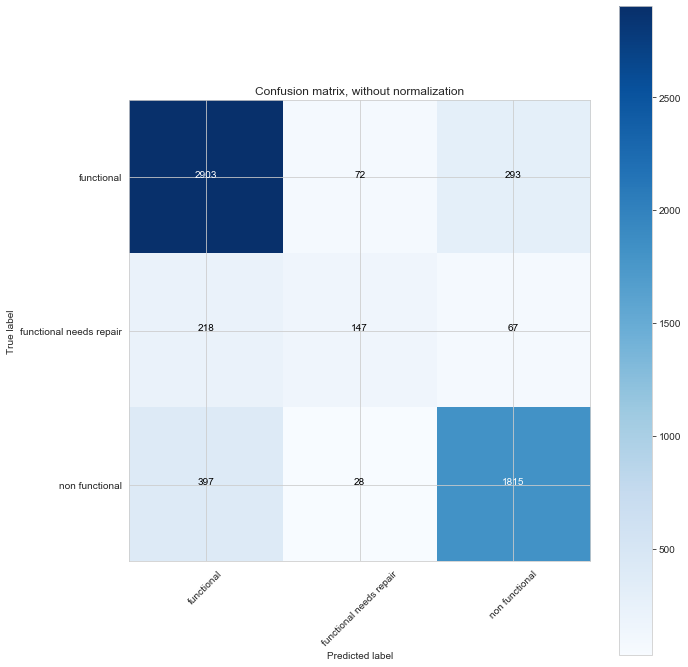

In [61]:
if run_cbclf:
    best_parameters.update({'verbose':False, 'random_state': SEED})
    cbclf, _ , model_results = clf_run_trial(CatBoostClassifier(verbose=False), best_parameters, best_parameters)

<p><br><br>
<h4>Build Final Model with ALL Labeled Data (Test + Validation)</h4>

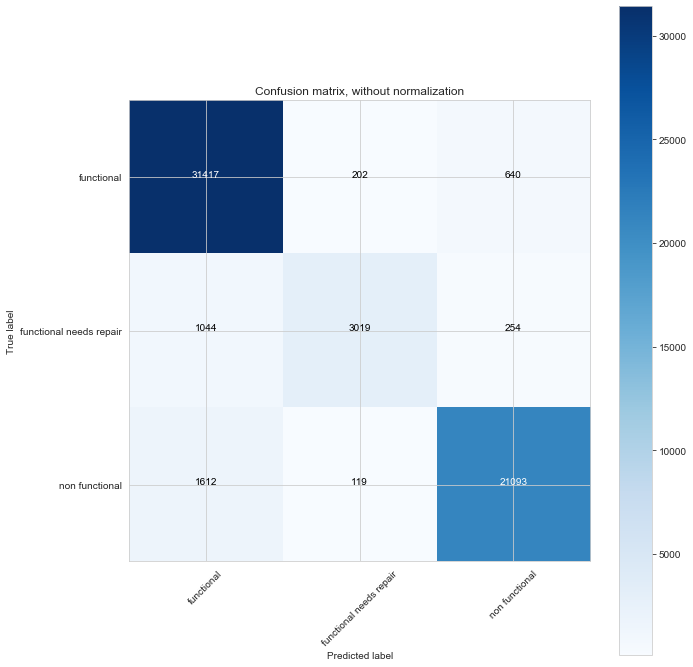

In [62]:
if run_cbclf:
    cbclf = CatBoostClassifier(verbose=False)
    del best_parameters['random_state']
    cbclf.set_params(**best_parameters)
    cbclf.fit(data_ALL_labeled, labels_encoded.status_group)
    pred_ALL = cbclf.predict(data_ALL_labeled)
    summarize_preds(cbclf, data_ALL_labeled, labels_encoded.status_group, pred_ALL, 'ALL Labeled', classes);
    
    if hasattr(cbclf, 'feature_importances_'):
        render_HTML("<p><br>", fname=get_trials_log_fname(cbclf))
        render_HTML("Feature Importances:", fname=get_trials_log_fname(cbclf))
        render_HTML(f"<pre>{pprint.pformat(model_results['modeling_results'][cbclf.__class__.__name__]['feature_importances'], indent=4)}</pre><p><br><br>", fname=get_trials_log_fname(cbclf))

<p><br><br>
<h4>Make Predictions with Final Model on Unlabeled Predictors</h4>

In [63]:
if run_cbclf:
    pred_unlabeled = cbclf.predict(data_unlabeled)
    df_pred_unlabeled = pd.concat([data_unlabeled.reset_index()[['id']], pd.DataFrame(pred_unlabeled, columns=['status_group_encoded'])], axis=1).set_index('id')
    df_pred_unlabeled['status_group'] = df_pred_unlabeled['status_group_encoded'].apply(lambda sg_encoded: classes[sg_encoded])
    df_pred_unlabeled = df_pred_unlabeled.drop('status_group_encoded', axis=1)
    df_pred_unlabeled.info()
    fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}CatBoostClassifier-preds-{digest}.csv"
    df_pred_unlabeled.to_csv(fname__preds_unlabeled, sep=',')
    print(f"updated {fname__preds_unlabeled}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  14850 non-null  object
dtypes: object(1)
memory usage: 232.0+ KB
updated model-results/CatBoostClassifier-preds-8a48b1bceea8e4f07957e8a9efbe76d8.csv


<p><br><br><br>
<h3>Ensemble: Voting Classifier: RandomForestClassifier + CatBoostClassifier + SVM(RBF Kernel)</h3>
<h4>Trials</h4>

In [64]:
# BUT we first have to build the SVM clf
run_svmclf = models_config['SVM_RBF']['run']
render_HTML(f"models_config['SVM_RBF']['run']: {run_svmclf}")

if run_svmclf:
    trials = models_config['SVM_RBF']['trials']

    render_HTML(f"models_config['SVM_RBF']['trials']['run']: {trials['run']}")
    if trials['run']:
        trials_list = trials['array']

        best_parameters = {}
        
        scaler = StandardScaler()
        # since dat must be scaled on for SVM, we must do this transformation "out-of-band"
        data_train_scaled = pd.DataFrame(scaler.fit_transform(data_train.astype(np.float32)), columns=data_train.columns, index=data_train.index)
        data_test_scaled = pd.DataFrame(scaler.transform(data_test.astype(np.float32)), columns=data_test.columns, index=data_test.index)
        
        _y_train = y_train_encoded.status_group.ravel()
        _y_test = y_test_encoded.status_group.ravel()

        n_iter = 100
        svmclf = svm.SVC(
            kernel='rbf', 
#             probability=False, 
            probability=True, # so that this can be used in a "soft" VotingClassifier
            gamma='scale', 
            decision_function_shape='ovr',
            break_ties=True
#             , class_weight='balanced'
        )
        param_distributions = {'gamma': reciprocal(0.0001, 1), 'C': uniform(1, 1000)}
        rnd_search_cv = RandomizedSearchCV(svmclf, param_distributions, n_iter=n_iter, verbose=1, cv=3)
        len_rs_ds = 1000
        rnd_search_cv.fit(data_train_scaled[:len_rs_ds], _y_train[:len_rs_ds])
        best_parameters =rnd_search_cv.best_params_

    else:
        best_parameters = models_config['SVM_RBF']['params']

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


<p><br>
<h4>Build Final Vaildation Model with best params</h4>

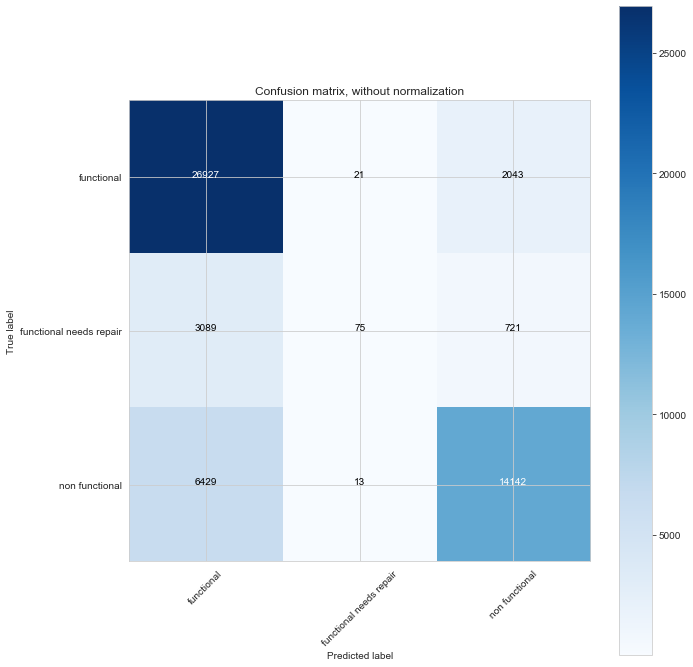

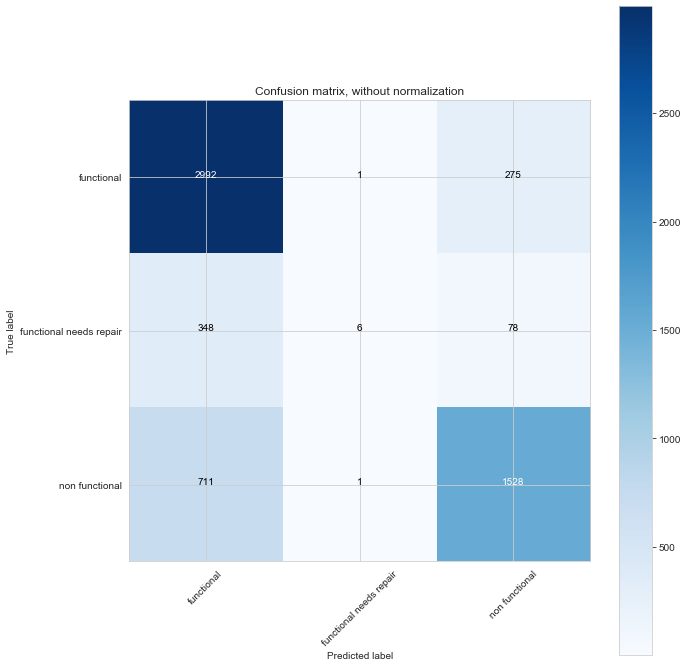

In [65]:
if run_svmclf:
    n_estimators = 4
    svmclf = OneVsRestClassifier( # BaggingClassifier(wrapping svm.SVC) within OneVsRestClassifier greatly improves training time vs using svm.SVC by itself
        BaggingClassifier(
            rnd_search_cv.best_estimator_, 
            max_samples=1.0/n_estimators, 
            n_estimators=n_estimators
        )
        , n_jobs=-1
    )
    svmclf.fit(data_train_scaled, _y_train)
    
    pred_train = svmclf.predict(data_train_scaled)
    _accuracy_train = summarize_preds(svmclf, data_train_scaled, y_train_encoded.status_group, pred_train, 'Training', classes)

    pred_test = svmclf.predict(data_test_scaled)
    _accuracy_test = summarize_preds(svmclf, data_test_scaled, y_test_encoded.status_group, pred_test, 'Testing', classes)

<p><br><br>
<h4>Build Final Model with ALL Labeled Data (Test + Validation)</h4>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   36.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    3.6s finished


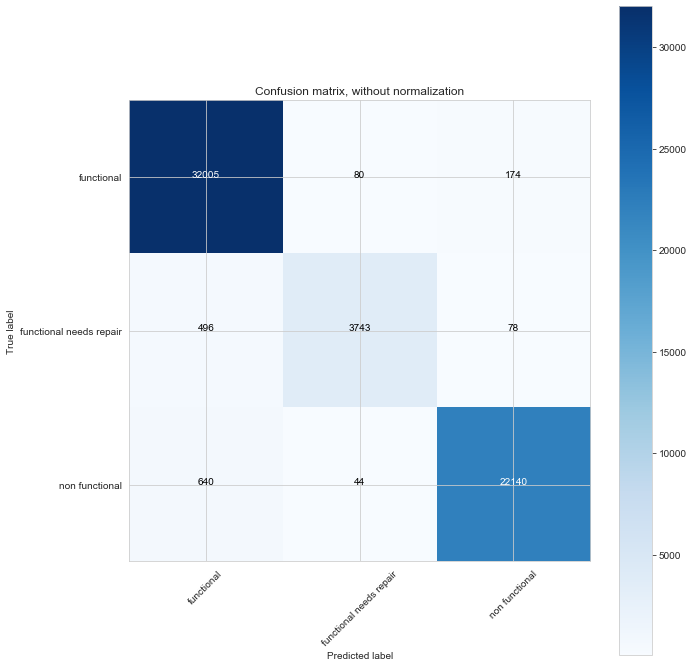

In [67]:
# if run_svmclf and run_cbclf and run_rfclf:
if run_cbclf and run_rfclf:
    params = {
        'estimators': [
            ('rf', rfclf),
            ('cb', cbclf), 
#             ('svm', svmclf) # initially I thought SVM would contribute to the ensemble with information (predictions) in which the other two classifiers were "weak" but empirical evidence shows this is not true
        ], 
        'voting': 'soft'
    }
    
    vclf = VotingClassifier(estimators=params['estimators'], voting=params['voting'])
    vclf.fit(data_ALL_labeled, labels_encoded.status_group)
    
    pred_ALL = vclf.predict(data_ALL_labeled)
    _accuracy_ALL = summarize_preds(vclf, data_ALL_labeled, labels_encoded.status_group, pred_ALL, 'ALL Labeled', classes)

<p><br><br>
<h4>Make Predictions with Final Model on Unlabeled Predictors</h4>

In [70]:
# if run_svmclf and run_cbclf and run_rfclf:
if run_cbclf and run_rfclf:
    pred_unlabeled = vclf.predict(data_unlabeled)
    df_pred_unlabeled = pd.concat([data_unlabeled.reset_index()[['id']], pd.DataFrame(pred_unlabeled, columns=['status_group_encoded'])], axis=1).set_index('id')
    df_pred_unlabeled['status_group'] = df_pred_unlabeled['status_group_encoded'].apply(lambda sg_encoded: classes[sg_encoded])
    df_pred_unlabeled = df_pred_unlabeled.drop('status_group_encoded', axis=1)
    df_pred_unlabeled.info()
#     fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}VC_ENSEMBLE-RF-CB-SVM-preds-{digest}.csv"
    fname__preds_unlabeled = f"{MODEL_RESULTS_DIR}VC_ENSEMBLE-RF-CB-preds-{digest}.csv"
    df_pred_unlabeled.to_csv(fname__preds_unlabeled, sep=',')
    print(f"updated {fname__preds_unlabeled}")  

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  14850 non-null  object
dtypes: object(1)
memory usage: 232.0+ KB
updated model-results/VC_ENSEMBLE-RF-CB-preds-8a48b1bceea8e4f07957e8a9efbe76d8.csv


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished


<p><br><br>
<h4>Save All Model Results to File</h4>

In [69]:
fm.save_json(model_results, f"{model_results_fname}")
print(f"updated {model_results_fname}")

updated model-results/models-results-8a48b1bceea8e4f07957e8a9efbe76d8.json
